## Part 1: Introduction

#### Project Background

In today's digital age, online food ordering has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the food experience daunting. To address this, we have developed **Restaurant Recommender AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about restaurants (restaurant name, rating, cuisine, city, price, etc.), Create a chatbot that helps users find the perfect restaurant for any occasion. It can consider factors like cuisine preferences, dietary restrictions, location, and user reviews to make tailored recommendations*.

#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 restaurants that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect restaurants.

## Part 2: System Design

#### Dataset

We have a dataset `restaurants.csv` where  each row describes the features of a single restaurant. The chatbot that we build will leverage LLMs to parse specific columns and provide recommendations

The chatbot should ask a series of questions to :
- Determine the user's requirments. For simplicity, we have used 5 features to encapsulate the user's needs. The 5 features are as follows:
    - Rating
    - Cuisine
    - Location
    - Dietary Restriction (veg/non-veg)
    - Budget

- Confirm if the user's requirements have been correctly captured at the end.

After that the chatbot lists down the top 3 restaurats that are the most relevant, and engages in further conversation to help the user find the best one.

#### Building the Chatbot

Now let's go ahead and understand the system design for the chatbot.

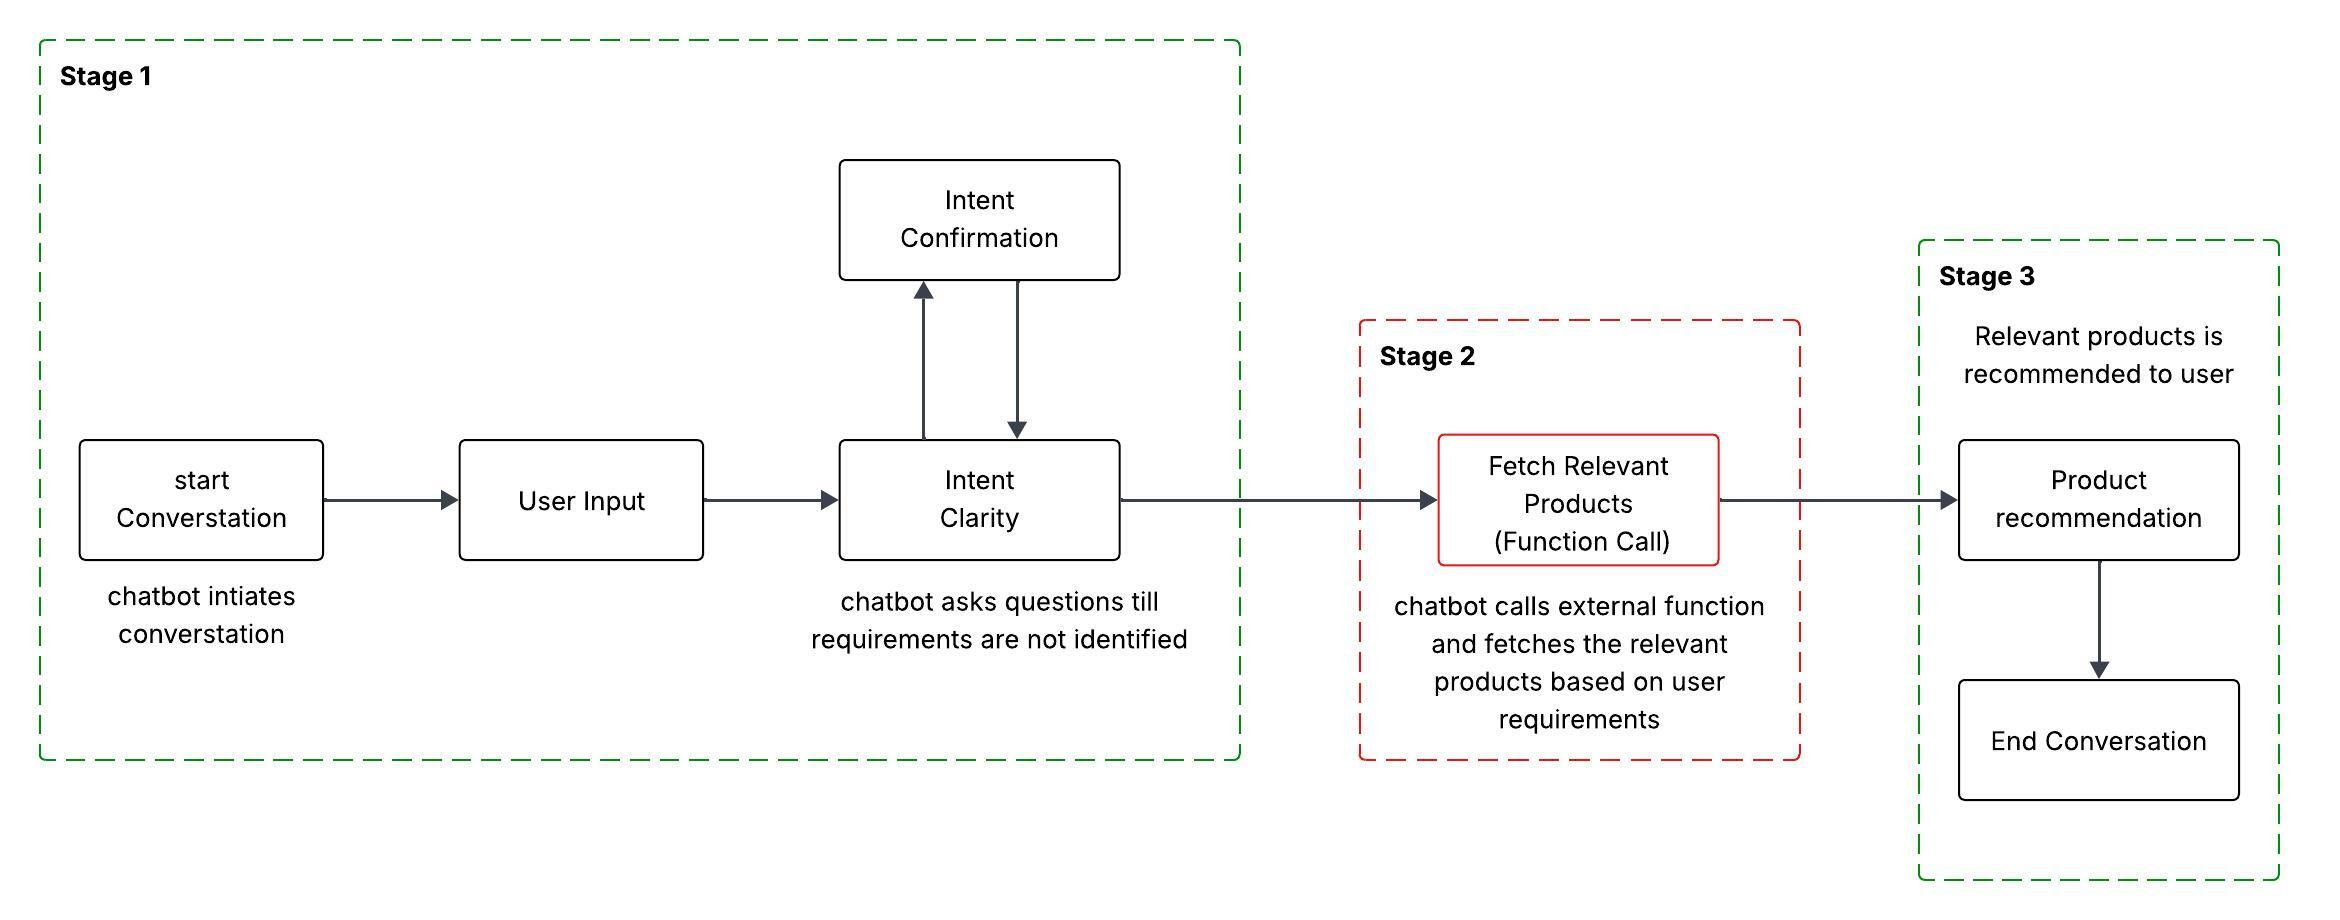

As shown in the image, the chatbot contains the following layers:
- Intent Clarity Layer
- Intent Confirmation Layer
- Function Calling Layer
- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_model_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's requirements clearly. Specifically, this checks if the following properties for the user has been captured or not - Rating, Cuisine, Location, Dietary Restriction, Budget
- `dictionary_present()`: This function checks if the final understanding of user's requirements is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_restaurants_with_user()`: This function compares the user's requirements with the different restaurants and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

## Part 3: Implementation

#### 3.1 Import the libraries


In [61]:
!pip install openai==0.28

In [62]:
import os,json,ast
import openai
import pandas as pd

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# read the API key
filepath = "/content/drive/MyDrive/upgrad/GenAI_Course_Master/BYOP_Restaurant_Recommender_AI/OpenAI_API_Key.txt"
openai.api_key = open(filepath, "r").read().strip()

In [65]:
# load the restaurants data

restaurents_file_path = "/content/drive/MyDrive/upgrad/GenAI_Course_Master/BYOP_Restaurant_Recommender_AI/restaurants.csv"
df = pd.read_csv(restaurents_file_path)

df.head()

,Restaurant_Name,Dining_Rating,Delivery_Rating,Dining Votes,Delivery_Votes,Cuisine,Place_Name,City,Item_Name,Best_Seller,Votes,Prices
0,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Platter Kebab Combo,BESTSELLER,84,249.0
1,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Rumali Shawarma,BESTSELLER,45,129.0
2,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Tandoori Salad,NaN,39,189.0
3,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken BBQ Salad,BESTSELLER,43,189.0
4,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Special Doner Wrap Combo,MUST TRY,31,205.0


#### Clean the dataset

1. Trim the column names
2. Remove the rows for blank columns - City, Budget, Item_Name
3. Trim columns - Cuisine, City, Item_Name
4. If Dining_Rating	or Delivery_Rating is blank consider rating as 3

In [66]:
def clean_data(df):
  df.columns = df.columns.str.strip()
  df = df.dropna(subset=['City', 'Prices', 'Item_Name'])
  df['Cuisine'] = df['Cuisine'].str.strip()
  df['City'] = df['City'].str.strip()
  df['Item_Name'] = df['Item_Name'].str.strip()
  df['Delivery_Rating'] = df['Delivery_Rating'].fillna(3)
  df['Dining_Rating'] = df['Dining_Rating'].fillna(3)
  return df

In [67]:
df = clean_data(df)

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`: This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's requirement clearly. Specifically, this checks if the following properties for the user has been captured or not
    - Rating
    - Cuisine
    - Location
    - Dietary Restriction (veg/non-veg)
    - Budget

In [132]:
def initialize_conversation():
  '''
  Returns a list [{"role" : "system" , "content" : system_message}]
  '''
  delimiter = "####"
  example_user_req = {'Rating': 'Good', 'Cuisine' : 'Fast Food', 'Location' : 'Hyderabad', 'Dietary Restriction': 'Non-veg', 'Budget': '500'}

  system_message = f"""

  You are an smart restaurant recommender and your goal is to find the best restaurant for a user.
  You need to ask relevant questions and understand the user requirements by analysing the user's responses.
  You final objective is to fill the values for the different keys ('Rating','Cuisine','Location','Dietary Restriction','Budget') in the python dictionary and be confident of the values.
  These key value pairs define the user's requirements.
  The python dictionary looks like this {{'Rating': 'values','Cuisine': 'values','Location': 'values','Dietary Restriction': 'values','Budget': 'values'}}
  The values currently in the dictionary are only representative values.

  {delimiter}Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalised.
  - Rating can have values as 'Good', 'Medium', 'Low'.
  - Cuisine can be Fast Food, Wraps, Biryani, Chinese ...etc.
  - Location is the city name in India.
  - Dietary Restriction can be Veg or Non-Veg.
  - The value for 'budget' should be a numerical value extracted from the user's response.
  - 'Budget' value needs to be greater than or equal to 100 INR. If the user says less than that, please mention that there are no restaurants in that range.
  - Do not randomly assign values to any of the keys. The values need to be inferred from the user's response.
  {delimiter}


  To fill the dictionary, you need to have the following chain of thoughts:

  {delimiter}
  Thought 1: Ask a question to understand the user's requirements. \n
  If their primary requirement from restaurant is unclear. Ask another question to comprehend their needs.
  You are trying to fill the values of all the keys ('Rating','Cuisine','Location','Dietary Restriction','Budget') in the python dictionary by understanding the user requirements.
  Identify the keys for which you can fill the values confidently using the understanding. \n
  Remember the instructions around the values for the different keys.
  Answer "Yes" or "No" to indicate if you understand the requirements and have updated the values for the relevant keys. \n
  If yes, proceed to the next step. Otherwise, rephrase the question to capture their requirement. \n
  {delimiter}

  {delimiter}
  Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
  Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to strengthen your understanding of the user's requirement.
  Answer "Yes" or "No" to indicate if you understood all the values for the keys and are confident about the same.
  If yes, move to the next Thought. If no, ask question on the keys whose values you are unsure of. \n
  It is a good practice to ask question with a sound logic as opposed to directly citing the key you want to understand value for.
  {delimiter}

  {delimiter}
  Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
  If you are not confident about any of the values, ask clarifying questions.
  {delimiter}

  Follow the above chain of thoughts and only output the final updated python dictionary. \n


  {delimiter}
  Here is a sample conversation between the user and assistant:
  User: "Hi, I am looking restaurants in Bangalore."
  Assistant: "Great! Bangalore has planty of restaurants with different cuisines and diet preferences. May I know if you are a vegiterian or Non-vegiterian"
  User: "I am veg."
  Assistant: "Thank you for providing that information. Bangalore has different cuisine restaurants which offers best vegiterian food. Do you have any special cuisine in mind?"
  User: "Yes, I would like to have fast food or Biryani."
  Assistant : "Thanks for sharing your choices. I am sure you might be looking for best rated restaurants?
  User: "No, even mid range also works for me."
  Assistant: "Thank you for the information. Let me search for best restaurents for you. But before that do you have any budget constraints?"
  User: "My max budget is 600 inr"
  Assistant: "{example_user_req}"
  {delimiter}

  Start with a short welcome message and encourage the user to share their requirements.

  output should be python dictionary having keys ('Rating','Cuisine','Location','Dietary Restriction','Budget') and values set to all the keys accordingly.


  """
  conversation = [{"role": "system", "content": system_message}]
  return conversation

In [69]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n\n  You are an smart restaurant recommender and your goal is to find the best restaurant for a user.\n  You need to ask relevant questions and understand the user requirements by analysing the user\'s responses.\n  You final objective is to fill the values for the different keys (\'Rating\',\'Cuisine\',\'Location\',\'Dietary Restriction\',\'Budget\') in the python dictionary and be confident of the values.\n  These key value pairs define the user\'s requirements.\n  The python dictionary looks like this {\'Rating\': \'values\',\'Cuisine\': \'values\',\'Location\': \'values\',\'Dietary Restriction\': \'values\',\'Budget\': \'values\'}\n  The values currently in the dictionary are only representative values.\n\n  ####Here are some instructions around the values for the different keys. If you do not follow this, you\'ll be heavily penalised.\n  - Rating can have values as \'Good\', \'Average\', \'Bad\'.\n  - Cuisine can be Fast Food, Wraps, Biryani, Chine

In [70]:
# define openai model for chat completion
def get_chat_model_completions(messages):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens = 900
    )
    return response.choices[0].message["content"]

Let's pass the initialized conversation debug_conversation and see what is the assistant's response.

In [71]:
debug_introduction = get_chat_model_completions(debug_conversation)
print(debug_introduction)

Hello! Welcome to the restaurant recommender. I'm here to help you find the best restaurant based on your preferences. Could you please share your requirements with me?


In [72]:
debug_user_input = "Hi, I am Anand. I am looking for restaurants in Bangalore."

In [73]:
debug_conversation.append({"role" : "user", "content" : debug_user_input})
debug_response_assistant = get_chat_model_completions(debug_conversation)
print(debug_response_assistant)

Great to have you here, Anand! Bangalore is known for its diverse culinary scene. To assist you better, could you please let me know if you have any specific dietary preferences like vegetarian or non-vegetarian?


- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [74]:
def moderation_check(user_input):
    response = openai.Moderation.create(input=user_input)
    moderation_output = response["results"][0]
    if moderation_output["flagged"] == True:
        return "Flagged"
    else:
        return "Not Flagged"

Let's test moderation on the `debug_user_input`

In [75]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now check moderation on the assistant's response `debug_response_assistant`.

In [76]:
moderation_check(debug_response_assistant)

'Not Flagged'

- implement `intent_confirmation_layer()` to check if user requirements are captured correctly or not.

In [77]:
def intent_confirmation_layer(response_assistant):
    delimiter = "####"
    prompt = f"""
    You are a senior evaluator who has an eye for detail.
    You are provided an input. You need to evaluate if the input has the following keys: 'Rating','Cuisine','Location','Dietary Restriction','Budget'
    Next you need to evaluate if the keys have the the values filled correctly.
    The values for all keys, except 'budget', should be properly filled as per earlier instruction and based on the importance as stated by user. The value for the key 'budget' needs to contain a number with currency.
    Output a string 'Yes' if the input contains the dictionary with the values correctly filled for all keys.
    Otherwise out the string 'No'.

    Here is the input: {response_assistant}
    Only output a one-word string - Yes/No.
    """


    confirmation = openai.Completion.create(
                                    model="gpt-3.5-turbo-instruct",
                                    prompt = prompt,
                                    temperature=0)


    return confirmation["choices"][0]["text"]

Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [78]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
print(debug_confirmation)


No


In [79]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

- `dictionary_present()`: This function checks if the final understanding of user's requirement is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right restaurant using dictionary matching.

In [80]:
def dictionary_present(response):
    delimiter = "####"
    user_req = {'Rating': 'Good', 'Cuisine' : 'Fast Food', 'Location' : 'Bangalore', 'Dietary Restriction': 'Non-veg', 'Budget': '500'}
    prompt = f"""
            You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract and return only the python dictionary from the input.
            The output should match the format as {user_req}.
            The output should contain the exact keys and values as present in the input.

            Here are some sample input output pairs for better understanding:
            {delimiter}
            input: - Rating: Bad - Cuisine: Fast Food - Location: Bangalore - Dietary Restriction: Veg  - Budget: 500 INR
            output: {{'Rating': 'Bad', 'Cuisine': 'Fast Food', 'Location': 'Bangalore', 'Dietary Restriction': 'Veg', 'Budget': '500'}}

            input: {{'Rating':     'Good', 'Cuisine':     'Fast Food', 'Location':    'Bangalore', 'Dietary Restriction': 'Veg', 'Budget': '900'}}
            output: {{'Rating': 'Good', 'Cuisine': 'Fast Food', 'Location': 'Bangalore', 'Dietary Restriction': 'Veg', 'Budget': '900'}}

            input: Here is your user requirement 'Rating': 'Good','Cuisine': 'Fast Food','Location': 'Bangalore','Dietary Restriction': 'Veg','Budget': '2000 INR'
            output: {{'Rating': 'Good','Cuisine': 'Fast food','Location': 'Bangalore','Dietary Restriction': 'Veg','Budget': '2000'}}
            {delimiter}

            Here is the input {response}

            """
    ## Legacy Completion Code is no longer supported. Use the ChatCompletion code below instead
    # response = openai.Completion.create(
    #     model="gpt-3.5-turbo-instruct",
    #     prompt=prompt,
    #     max_tokens = 2000
    #     # temperature=0.3,
    #     # top_p=0.4
    # )
    # return response["choices"][0]["text"]
    conversation = [{"role": "system", "content": prompt}]
    # print(conversation)
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0125",
        messages = conversation
    )
    return response.choices[0].message.content

Let's start by passing the `debug_response_assistant`.

In [120]:
debug_response_assistant_n = f"""

Based on the information you have provided, I have updated the values in the dictionary as follows:

{{'Rating': 'Medium','Cuisine': 'Chinese','Location': 'Bangalore','Dietary Restriction': 'Non-Veg','Budget': '2000'}}


Is there anything else I can assist you with?
"""
#Note that you are using double curly braces

In [121]:
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'Rating': 'Medium','Cuisine': 'Chinese','Location': 'Bangalore','Dietary Restriction': 'Non-Veg','Budget': '2000'}


What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [122]:
debug_response_assistant_n = f"""Thank you for providing your budget. Based on your budget of 50,000 INR, I will consider this while recommending suitable laptop options for you.
Here is the final recommendation for your laptop:

- Rating: Medium
- Cuisine: Chinese
- Location: Bangalore
- Dietary Restriction: Non-Veg
- Budget: 800 INR

Please note that these specifications are based on your requirements within your budget. Let me know if there's anything else I can assist you with!"""

In [123]:
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'Rating': 'Medium', 'Cuisine': 'Chinese', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '800'}


### 3.3 Implementing Relevant Restaurant Fetch Function Call


In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary, and extract the top restaurant recommendations based on that. Here are the functions that we will use to help us implement the information extraction and restaurant matching layers


- `restaurant_map_layer()`: This function is responsible for extracting key features and criteria from restaurant row. Here's a breakdown of how it works:
    - Uses a prompt that assign it the role of a restaurant Specifications Classifier, whose objective is to extract key features and classify them based on restaurant row.
    - Provide step-by-step instructions for extracting restaurant features from row.
    - Assign specific rules for each feature (e.g., Rating, Cuisine, Location, Dietary Restriction, Budget) and associate them with the appropriate classification value (Low, Medium, or High).
    - Includes Few Shot Prompting(sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction
    and classification process.
- `extract_dictionary_from_string()`: This function takes in the output of the previous layer and extracts the user requirements dictionary

- `compare_restaurants_with_user_requirements()`: This function compares the user's requirements with the different restaurants and come back with the top recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the restaurants based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each restaurant based on how well it matches the user's requirements.
    - Sort the restaurants based on their scores in descending order.
    - Return the top 3 restaurants as a JSON-formatted string.

In [86]:
df[df['City'] == 'Bangalore'].iloc[123]

,65573
Restaurant_Name,Domino's Pizza
Dining_Rating,3.4
Delivery_Rating,3.7
Dining Votes,86
Delivery_Votes,0
Cuisine,Fast Food
Place_Name,MG Road
City,Bangalore
Item_Name,Boneless Chicken Wings Peri-Peri
Best_Seller,NaN


#### 3.3.1 Implement restaurant map layer

In [87]:
def restaurant_map_layer(row):
  delimiter = "#####"
  restra_spec = {
      "Rating":"(Overall rating bad/medium/good)",
      "Cuisine":"(Cuisine which the restaurant offers)",
      "Location":"(City where the restaurant is located)",
      "Dietary Restriction":"(veg or Non-Veg)",
      "Budget":"(Price for the item)"
  }

  values = {'bad','medium','good'}
  primary_restaurant_features = {'Dining_Rating', 'Delivery_Rating', 'Cuisine', 'City', 'Item_Name', 'Prices'}

  prompt=f"""
  You are a restaurant Specifications Classifier whose job is to extract the key features of restaurant as per their requirements.
  To analyze each restaurant, perform the following steps:
  Step 1: Extract the restaurant's {primary_restaurant_features} from the row {row}
  Step 2: Create restra_spec from extracted features. Use below rule to calculate value for each key in restra_spec
  Step 3: Classify Rating in {restra_spec} into {values} based on the rating rule given below \
  {delimiter}
  Rating: low: < if avg of Dining_Rating and Delivery_Rating is less than 3  > , \n
  medium: < if avg of Dining_Rating and Delivery_Rating is greater or equal to 3 but less than 4  > , \n
  high: < if avg of Dining_Rating and Delivery_Rating is greater or equal to 4 > , \n

  Cuisine:  < take value from Cuisine column present in {row} >  \n

  Location: < take value from City column present in {row} >  \n

  Dietary Restriction: Veg: < if item_name in {row} is Vegiterian > , \n
  Non-Veg: < if item_name in {row} is Non-Vegiterian >  \n

  Budget: low: < take value from Prices column present in {row}>
  {delimiter}

  {delimiter}
  Here are some input output pairs for few-shot learning:
  input1: "Restaurant_Name Domino's Pizza Dining_Rating 3.4 Delivery_Rating 3.7 Dining Votes 86 Delivery_Votes 0 Cuisine Fast Food Place_Name MG Road City Bangalore Item_Name Farmhouse Pizza Best_Seller BESTSELLER Votes 22 Prices 269.0"
  output1: {{'Rating': 'medium','Cuisine':'Fast Food','Location':'Bangalore','Dietary Restriction':'Veg','Budget':'269'}}

  input2: "Restaurant_Name	KFC Dining_Rating	4.0 Delivery_Rating	3.7 Dining Votes	159 Delivery_Votes	660 Cuisine	Beverages Place_Name	Brigade Road City	Bangalore Item_Name	Double Chicken Roll Best_Seller	NaN Votes	0 Prices	168.57"
  output2: {{'Rating': 'medium', 'Cuisine': 'Beverages', 'Location': 'Bangalore', 'Dietary Restriction':'Non-Veg', 'Budget':'168.57'}}

  input3: "Restaurant_Name	Brik Oven Dining_Rating	4.6 Delivery_Rating	3.9 Dining Votes	0 Delivery_Votes	0 Cuisine	Shake Place_Name	Church Street City	Bangalore Item_Name	Signature Mammas Ricotta bomb Combo (NON-VEG) Best_Seller	NaN Votes	0 Prices	845.0"
  output3: {{'Rating': 'good', 'Cuisine': 'Shake', 'Location': 'Bangalore','Dietary Restriction': 'Non-Veg', 'Prices': '845'}}
  {delimiter}

  Follow the above instructions step-by-step and output the dictionary {restra_spec} for the following {row}.
  """

#see that we are using the Completion endpoint and not the Chatcompletion endpoint

  response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=prompt,
    max_tokens = 2000,
    # temperature=0.3,
    # top_p=0.4
    )
  return response["choices"][0]["text"]


In [88]:
# take string:row as argument and perform below steps-
# 1. create a blank dict and fill dict with below keys
# 2. Location  = row.City
# 3. Cuisine = row.Cusine
# 4. Budget = row.Prices
# 5. Rating = avg(row.Dining_Rating, row.Delivery_Rating) if avg<3 then low, if avg>=3 but < 4 then medium else good
# 6. Dietary Restriction = Non-Veg if row.item_name contains "Non-veg, chicken" else Veg

def restaurant_map_layer_python(row):
  restaurant_dict = {}
  restaurant_dict["Location"] = row.City
  restaurant_dict["Cuisine"] = row.Cuisine
  restaurant_dict["Budget"] = float(row.Prices)
  avg_rating = (row.Dining_Rating + row.Delivery_Rating) / 2

  if avg_rating < 3:
      restaurant_dict["Rating"] = "Low"
  elif 3 <= avg_rating < 4:
      restaurant_dict["Rating"] = "Medium"
  else:
      restaurant_dict["Rating"] = "Good"

  item_name_lower = str(row.Item_Name).lower()

  if "non-veg" in item_name_lower or "chicken" in item_name_lower:
      restaurant_dict["Dietary Restriction"] = "Non-Veg"
  else:
      restaurant_dict["Dietary Restriction"] = "Veg"
  return restaurant_dict



In [89]:
# test the product map from random samples from dataset
restaurant_map_layer_python(df[df['City'] == 'Bangalore'].iloc[123])

{'Location': 'Bangalore',
 'Cuisine': 'Fast Food',
 'Budget': 189.0,
 'Rating': 'Medium',
 'Dietary Restriction': 'Non-Veg'}

In [90]:
# test the product map from random samples from dataset
print(restaurant_map_layer(df[df['City'] == 'Bangalore'].iloc[123]))




{'Rating': 'medium', 'Cuisine': 'Fast Food', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '189.0'}


#### 3.3.2 Fetch python dict from dict string

In [91]:
import ast
import re

def extract_dictionary_from_string(string):
    regex_pattern = r"\{[^{}]+\}"

    dictionary_matches = re.findall(regex_pattern, string)

    # Extract the first dictionary match and convert it to lowercase
    if dictionary_matches:
        dictionary_string = dictionary_matches[0]
        # dictionary_string = dictionary_string.lower()

        # Convert the dictionary string to a dictionary object using ast.literal_eval()
        dictionary = ast.literal_eval(dictionary_string)
    return dictionary

In [92]:
string = " \n \t           Output: {{'Rating': 'medium', 'Cuisine': 'Beverages', 'Location': 'Bangalore', 'Dietary Restriction':'Non-Veg', 'Budget':'168.57'}}ad"
extracted_dict = extract_dictionary_from_string(string)
print(extracted_dict)

{'Rating': 'medium', 'Cuisine': 'Beverages', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '168.57'}


#### 3.3.3 Compare restaurants with the user requirements

In [93]:
# filter dataset based on location, budget, cuisine
def fetchFilteredRestaurents(location, budget, cuisine):
  # print("location", location)
  # print("budget", budget)
  # print("cuisine", cuisine)
  filtered_df = df[df['City'] == location]
  # print("filtered_df shape after city", filtered_df.shape)
  filtered_df = filtered_df[filtered_df['Prices'] <= budget]
  # print("filtered_df shape after budget", filtered_df.shape)
  filtered_df = filtered_df[filtered_df['Cuisine'] == cuisine]
  # print("filtered_df shape after Cuisine", filtered_df.shape)
  return filtered_df

In [94]:
def compare_restaurants_with_user_requirements(user_req_string):
  # extract python dict from string
  user_requirements = extract_dictionary_from_string(user_req_string)

  # filter dataset based on location, budget, cuisine
  filtered_df = fetchFilteredRestaurents(user_requirements.get('Location'), float(user_requirements.get('Budget')), user_requirements.get('Cuisine'))
  # print("filtered_df shape", filtered_df.shape)

  # copy the filtered data
  filtered_restra = filtered_df.copy()

  # create new column and store restra_features using restaurant_map_layer
  filtered_restra['restra_features'] = filtered_restra.apply(lambda row: restaurant_map_layer_python(row), axis=1)
  # print("filtered_restra shape", filtered_restra.shape)

  # generate score based on given user requirement and restra_features

  # 1. create new column score and store 0
  filtered_restra['score'] = 0
  # 2. generate score based on comparing rating and Dietary Restriction for each row of filtered data set
  for index, row in filtered_restra.iterrows():
    # restra_features = extract_dictionary_from_string(row['restra_features'])
    restra_features = row['restra_features']
    # print("restra_features", restra_features)
    score = 0
    if user_requirements.get('Rating') == restra_features.get('Rating'):
      score += 1
    if user_requirements.get('Dietary Restriction') == restra_features.get('Dietary Restriction'):
      score += 1
    filtered_restra.at[index, 'score'] = score


  # Sort the restaurants by score in descending order
  filtered_restra = filtered_restra.sort_values(by='score', ascending = False)

  # return filtered restra dataframe where score is greater than 2
  return filtered_restra[filtered_restra['score'] >= 2]

In [95]:
# fetch top 5 restaurants from filtered dataframe using groupby on restaurant name and return as a list
def fetchTop5Restaurants(filtered_restra_df):
  """
  Fetch top 5 rows per restaurant and return as a JSON array.
  """
  top5_df = filtered_restra_df.groupby('Restaurant_Name').head(5)

  result = [
      {
            "index": int(idx),
            "restaurant_name": row["Restaurant_Name"]
      }
        for idx, row in top5_df.iterrows()
  ]

  return result

In [124]:
# test compare_restaurants_with_user_requirements with sample user requirement
# print("== user requirement ===")
print(response_dict_n)
# print("== restra recommendation ===")
filtered_restra_df = compare_restaurants_with_user_requirements(response_dict_n)
print("filtered_restra_df shape ", filtered_restra_df.shape)
# top5RecommendedRestras = fetchTop5Restaurants(filtered_restra_df)
# print("top5RecommendedRestras ", top5RecommendedRestras)


{'Rating': 'Medium', 'Cuisine': 'Chinese', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '800'}
filtered_restra_df shape  (588, 14)


#### Writing function call for fetching recommended restaurants

In [97]:
# 1. Define a list of callable tools for the model
tools = [
    {
        "type": "function",
        "name": "compare_restaurants_with_user_requirements",
        "description": "Compare restaurants with user requirements and respond with filtered dataframe.",
        "parameters": {
            "type": "object",
            "properties": {
                "user_req_string": {
                    "type": "string",
                    "description": "user requirements in form of dictionary. Having keys like Rating Cuisine, Location, Dietary Restriction, Budget"
                },
            },
            "required": ["user_req_string"],
        },
    },
]


# 2. Prompt the model with tools defined
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0125",
    messages=[{"role": "user", "content": "user requirements are present in the dictionary " + response_dict_n }],
    functions=tools,
    function_call="auto"
)

# Save function call outputs for subsequent requests
# input_list += response["choices"][0]["message"]

# print("input list", input_list)

# save the function response in message
message = response["choices"][0]["message"]

# call the pythion function
if "function_call" in message:
    function_name = message["function_call"]["name"]
    arguments = json.loads(message["function_call"]["arguments"])
    print("arguments", arguments)

    if function_name == "compare_restaurants_with_user_requirements":
        function_response = compare_restaurants_with_user_requirements(**arguments)
        print("function_response", function_response.shape)

        # provide function call result to model
        # input_list.append({
        #     "role": "function",
        #     "name": compare_restaurants_with_user_requirements,
        #     "content": function_response
        # })


arguments {'user_req_string': "{'Rating': 'medium', 'Cuisine': 'Biryani', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '800'}"}
function_response (0, 14)


In [98]:
def function_call_for_filtered_data_set(user_requirements_dict):

  # 1. Define a list of callable tools for the model
  tools = [
      {
          "type": "function",
          "name": "compare_restaurants_with_user_requirements",
          "description": "Compare restaurants with user requirements and respond with filtered dataframe.",
          "parameters": {
              "type": "object",
              "properties": {
                  "user_req_string": {
                      "type": "string",
                      "description": "user requirements in form of dictionary. Having keys like Rating Cuisine, Location, Dietary Restriction, Budget"
                  },
              },
              "required": ["user_req_string"],
          },
      },
  ]


  # 2. Prompt the model with tools defined
  response = openai.ChatCompletion.create(
      model="gpt-3.5-turbo-0125",
      messages=[{"role": "user", "content": "user requirements are present in the dictionary " + user_requirements_dict }],
      functions=tools,
      function_call="auto"
  )

  # save the function response in message
  message = response["choices"][0]["message"]

  # 3. Return function response
  function_response = None

  # call the python function
  if "function_call" in message:
      function_name = message["function_call"]["name"]
      arguments = json.loads(message["function_call"]["arguments"])
      # print("arguments", arguments)

      if function_name == "compare_restaurants_with_user_requirements":
          function_response = compare_restaurants_with_user_requirements(**arguments)
          # print("function_response", function_response.shape)

  return function_response


In [125]:
# test function call
# sample = "{'Rating': 'Medium', 'Cuisine': 'Chinese', 'Location': 'Bangalore', 'Dietary Restriction': 'Non-Veg', 'Budget': '800'}"
# print(response_dict_n)
function_call_for_filtered_data_set(response_dict_n)
# function_call_for_filtered_data_set(sample)

,Restaurant_Name,Dining_Rating,Delivery_Rating,Dining Votes,Delivery_Votes,Cuisine,Place_Name,City,Item_Name,Best_Seller,Votes,Prices,restra_features,score
97969,Tapri By The Corner,4.2,3.7,179,0,Chinese,Koramangala 5th Block,Bangalore,Chicken Fried Rice,NaN,78,169.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
97974,Tapri By The Corner,4.2,3.7,179,0,Chinese,Koramangala 5th Block,Bangalore,Chicken Noodles,NaN,14,169.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67482,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Chicken Hakka Noodles - Light Eaters,NaN,0,139.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67483,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Chicken Chinese Fried Rice - Half,NaN,13,209.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67493,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Chilli Oyster Chicken Dry,NaN,0,309.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67467,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Chicken Fried Rice,NaN,0,309.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67468,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Kung Pao Chicken Bowl,NaN,17,309.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67470,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Chilli Chicken Bowl,NaN,10,299.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2
67471,Chinese Wok,3.3,4.0,2,593,Chinese,Malleshwaram,Bangalore,Schezwan Chicken Bowl,NaN,0,299.0,"{'Location': 'Bangalore', 'Cuisine': 'Chinese'...",2


In [100]:
# group by filtered_restra_df on Restaurant_Name
filtered_restra_df['Restaurant_Name'].value_counts()

,count
Restaurant_Name,


### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_restaurants_with_user_requirements` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



In [101]:
def initialize_conv_reco(filtered_restra_df):
    system_message = f"""
    You are an intelligent restaurant recommendation expert and you are tasked with the objective to \
    solve the user requirement about restaurants from the dataframe: {filtered_restra_df}.\
    You should keep the user requirement in mind while answering the questions.\

    {filtered_restra_df} contains filtered data set based on user requirements. Perform the below step in order to generate the recommendations:
    1. Fetch unique restaurant name from data set. as <Restaurant_Name>
    2. Fetch place_name from data set for this restaurant and map it as <Place_Name>
    3. Fetch unique item_name from data set for each unique restaurants and map those to <Recommended_Items>

    Output the each recommendations in the below format-

    1. Start with a brief summary of each restaurant
    2. <Restaurant_Name> : <Place_Name>
        Recommended Items:
          <Recommended Items>

    """
    conversation = [{"role": "system", "content": system_message }]
    return conversation

In [126]:
debug_conversation_reco = initialize_conv_reco(filtered_restra_df)
print(debug_conversation_reco)

[{'role': 'system', 'content': "\n    You are an intelligent restaurant recommendation expert and you are tasked with the objective to     solve the user requirement about restaurants from the dataframe:            Restaurant_Name  Dining_Rating  Delivery_Rating  Dining Votes  \\\n97969  Tapri By The Corner            4.2              3.7           179   \n97974  Tapri By The Corner            4.2              3.7           179   \n67482          Chinese Wok            3.3              4.0             2   \n67483          Chinese Wok            3.3              4.0             2   \n67493          Chinese Wok            3.3              4.0             2   \n...                    ...            ...              ...           ...   \n67467          Chinese Wok            3.3              4.0             2   \n67468          Chinese Wok            3.3              4.0             2   \n67470          Chinese Wok            3.3              4.0             2   \n67471          Chinese Wo

Let's see what the assistant responds with the new initialization.

In [127]:
debug_recommendation = get_chat_model_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

Based on the user requirements, here are the restaurant recommendations:

1. **Tapri By The Corner**:
   - **Location**: Koramangala 5th Block, Bangalore
   - **Dining Rating**: 4.2, **Delivery Rating**: 3.7
   - **Dining Votes**: 179, **Delivery Votes**: 0

   **Recommended Items**:
   - Chicken Fried Rice
   - Chicken Noodles

2. **Chinese Wok**:
   - **Location**: Malleshwaram, Bangalore
   - **Dining Rating**: 3.3, **Delivery Rating**: 4.0
   - **Dining Votes**: 2, **Delivery Votes**: 593

   **Recommended Items**:
   - Chicken Hakka Noodles - Light Eaters
   - Chicken Chinese Fried Rice - Half
   - Chilli Oyster Chicken Dry
   - Chicken Fried Rice
   - Kung Pao Chicken Bowl
   - Chilli Chicken Bowl
   - Schezwan Chicken Bowl
   - Chicken Manchow Soup with Crispy Noodles

These are the recommended items from the respective restaurants based on the user requirements.



In [104]:
def recommendation_layer(filtered_restra_df):
  # 1. initialize recommendation converstaion
  initialize_conv_reco(filtered_restra_df)

  # 2. generate recommendation
  recommendations = get_chat_model_completions(debug_conversation_reco)
  # print("recommendations", recommendations)

  # 3. return recommendations
  return recommendations

In [105]:
# test recommendation_layer
recommendation_layer(filtered_restra_df)

"Based on the user requirements, let's generate restaurant recommendations:\n\n1. Start with a brief summary of each restaurant:\n\n2. Restaurant_Name: ABC Restaurant\n   Place_Name: XYZ Place\n   Recommended Items:\n     - Item1\n     - Item2\n     - Item3\n\n3. Restaurant_Name: DEF Restaurant\n   Place_Name: PQR Place\n   Recommended Items:\n     - Item4\n     - Item5\n\n4. Restaurant_Name: GHI Restaurant\n   Place_Name: LMN Place\n   Recommended Items:\n     - Item6\n     - Item7\n     - Item8\n\n5. Restaurant_Name: JKL Restaurant\n   Place_Name: STU Place\n   Recommended Items:\n     - Item9\n     - Item10\n\n6. Restaurant_Name: MNO Restaurant\n   Place_Name: VWX Place\n   Recommended Items:\n     - Item11\n     - Item12\n     - Item13\n\n7. Restaurant_Name: PQR Restaurant\n   Place_Name: YZA Place\n   Recommended Items:\n     - Item14\n     - Item15\n\n8. Restaurant_Name: STU Restaurant\n   Place_Name: BCD Place\n   Recommended Items:\n     - Item16\n     - Item17\n\n9. Restaurant

Now, you can converse with the chatbot on the filtered products.

In [106]:
debug_conversation_reco.append({"role": "user", "content": "This is user requirement" + response_dict_n})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [107]:
debug_user_input = "Which is ideal for with less species?"

In [108]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_model_completions(debug_conversation_reco)
print('\n' + debug_response_asst_reco + '\n')


Based on the user requirement for a restaurant with less spice, the following recommendation is suitable:

1. Restaurant_Name: DEF Restaurant
   Place_Name: PQR Place
   Recommended Items:
     - Item4
     - Item5

DEF Restaurant at PQR Place is ideal for those looking for dishes with less spice.



### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [109]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()
    introduction = get_chat_model_completions(conversation)
    print(introduction + '\n')
    top_3_restra = None
    user_input = ''

    while(user_input != "exit"):
        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            print("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_restra is None:
            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_model_completions(conversation)

            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            confirmation = intent_confirmation_layer(response_assistant)

            moderation = moderation_check(confirmation)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            if "No" in confirmation:
                conversation.append({"role": "assistant", "content": response_assistant})
                print("\n" + response_assistant + "\n")
                # print('\n' + confirmation + '\n')
            else:
                # print("\n" + response_assistant + "\n")
                # print('\n' + confirmation + '\n')
                response = dictionary_present(response_assistant)

                moderation = moderation_check(response)
                if moderation == 'Flagged':
                    print("Sorry, this message has been flagged. Please restart your conversation.")
                    break
                print("\n Here is the user requirements: ")
                print('\n' + response + '\n')
                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")

                #function call for finding the filtered dataset based on user requirement
                filtered_restra_df = function_call_for_filtered_data_set(response)

                conversation_reco = initialize_conv_reco(filtered_restra_df)
                recommendation = get_chat_model_completions(conversation_reco)

                # topRecommendations = recommendation_layer(filtered_restra_df)

                conversation_reco.append({"role": "user", "content": "This is user requirement" + response})

                conversation_reco.append({"role": "assistant", "content": recommendation})

                print("\n Based on your preferences here are the recommended restaurants \n")

                print(recommendation + '\n')

        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_model_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [133]:
# debug dialogue_mgmt_system
dialogue_mgmt_system()

Hello! Welcome to the restaurant recommender. I can help you find the best restaurant based on your preferences. Could you please share your requirements with me?

I am Ashish. I am looking for restaurants in Bangalore

Great to have you here, Ashish! Bangalore is known for its diverse culinary scene. To assist you better, could you please let me know if you have any specific dietary preferences like vegetarian or non-vegetarian?

Non-Veg

Thank you for letting me know, Ashish. Since you prefer non-vegetarian food, Bangalore offers a wide range of options. Do you have any particular cuisine in mind that you would like to explore, such as Chinese, Indian, or Italian?

I would like Chinese

Thank you for sharing your preference, Ashish. Chinese cuisine in Bangalore is quite popular. Are you looking for highly rated restaurants or would you prefer something more budget-friendly?

Even mid rating is also fine

Got it, Ashish. Mid-rated restaurants in Bangalore offer a good balance between 